In [1]:
import os
import sys
import torch
import seqdata as sd
import seqpro as sp
from eugene import models
from eugene import train
sys.path.append("/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/scripts")
from DeepMEL import DeepMEL

In [2]:
dataset_name = "multiome_cells_all_peaks"
data_dir = f"/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/{dataset_name}"
output_dir = "/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models"

In [3]:
sdata = sd.open_zarr(os.path.join(data_dir, f"{dataset_name}.train.zarr"))

In [4]:
# Rename _topics dim to _targets
sdata = sdata.rename_vars({"ohe_seqs": "ohe_seq", "topics": "target"})
sdata = sdata.rename_dims({"_topic": "_targets"})
n_topics = sdata.dims["_targets"]
sdata[["ohe_seq", "target"]].load()

<xarray.Dataset>
Dimensions:  (_sequence: 138353, length: 500, _ohe: 4, _targets: 37)
Dimensions without coordinates: _sequence, length, _ohe, _targets
Data variables:
    ohe_seq  (_sequence, length, _ohe) uint8 0 0 0 1 1 0 0 0 ... 0 0 0 1 0 0 1 0
    target   (_sequence, _targets) float64 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0

In [5]:
arch = DeepMEL(
    input_len=500, 
    output_dim=n_topics,
    conv_kwargs={
        "conv_channels": [1024],  
    },
)

In [6]:
model = models.SequenceModule(
    arch=arch,
    task="multilabel_classification",
    loss_fxn="bce",
    optimizer="adam",
    metric_kwargs={
        "task": "multilabel",
        "num_labels": n_topics
    }
)

In [7]:
models.init_weights(model)

In [8]:
train_sdata = sdata.sel(_sequence=(sdata["train_val"] == True).compute())  # noqa
val_sdata = sdata.sel(_sequence=(sdata["train_val"] == False).compute())  # noqa

In [9]:
train_dataloader = sd.get_torch_dataloader(
    train_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    transforms={
        "ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1),
        "target": lambda x: torch.tensor(x, dtype=torch.float32)
    },
    shuffle=True,
    drop_last=True
)
val_dataloader = sd.get_torch_dataloader(
    val_sdata,
    sample_dims=["_sequence"],
    variables=["ohe_seq", "target"],
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    transforms={
        "ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1),
        "target": lambda x: torch.tensor(x, dtype=torch.long)
    },
    shuffle=False,
    drop_last=False
)

In [10]:
batch = next(iter(train_dataloader))

In [11]:
from eugene.models.base._metrics import calculate_metric

In [12]:
calculate_metric(model.train_metric, "auroc", model.metric_kwargs, model(batch["ohe_seq"]), batch["target"])

In [13]:
model.train_metric.compute()

tensor(0.5023)

In [14]:
train.fit(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    gpus=1,
    epochs=25,
    log_dir=os.path.join(output_dir, dataset_name),
    name=f"{dataset_name}.DeepMEL.revision",
    version="v0"
)

No seed set


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Scratch

In [32]:
train.fit_sequence_module(
    model=model,
    sdata=train_sdata,
    seq_key="ohe_seq",
    target_keys=["target"],
    train_key="train_val",
    in_memory=True,
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    transforms={
        "ohe_seq": lambda x: torch.tensor(x, dtype=torch.float32).permute(0, 2, 1),
        "target": lambda x: torch.tensor(x, dtype=torch.float32)
    },
    log_dir=os.path.join(output_dir, dataset_name),
    name=f"{dataset_name}.DeepMEL.revision",
    version="v0"
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['target'] into memory
No seed set


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type            | Params
-------------------------------------------------
0 | arch         | DeepMEL         | 1.3 M 
1 | train_metric | MultilabelAUROC | 0     
2 | val_metric   | MultilabelAUROC | 0     
3 | test_metric  | MultilabelAUROC | 0     
-------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([128, 37]) and torch.Size([128]).

In [28]:
model(batch).squeeze().shape

torch.Size([128, 37])

In [42]:
train.fit_sequence_module?

Signature:
train.fit_sequence_module(
    model: pytorch_lightning.core.module.LightningModule,
    sdata: 'xr.Dataset',
    seq_key: str = None,
    target_keys: Union[str, List[str]] = None,
    in_memory: bool = False,
    train_key: str = 'train_val',
    epochs: int = 10,
    gpus: int = None,
    batch_size: int = None,
    num_workers: int = None,
    prefetch_factor: int = None,
    transforms=None,
    drop_last=True,
    logger: str = 'tensorboard',
    log_dir: os.PathLike = None,
    name: str = None,
    version: str = None,
    early_stopping_metric: str = 'val_loss_epoch',
    early_stopping_patience=5,
    early_stopping_verbose=False,
    model_checkpoint_k=1,
    model_checkpoint_monitor: str = 'val_loss_epoch',
    seed: int = None,
    return_trainer: bool = False,
    **kwargs,
)
Docstring:
Train the model using PyTorch Lightning.

Parameters
----------
model : BaseModel
    The model to train.
sdata : SeqData
    The SeqData object to train on.
target_keys : str o

In [9]:
from eugene import plot as pl

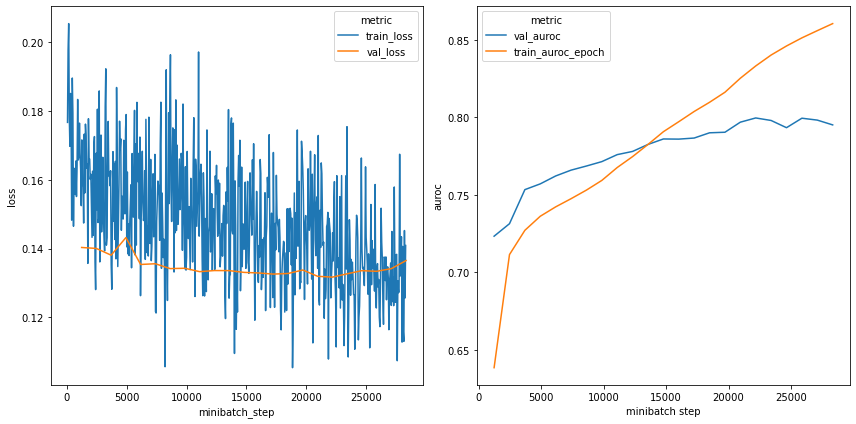

In [11]:
pl.training_summary("/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models/DeepSTRESS/beta_cells_all_peaks", metric="auroc")

## Script

In [ ]:
%%bash
dataset_name=beta_cells_all_peaks
data_dir=/cellar/users/aklie/data/ml4gland/collabs/er_stress_regulation/${dataset_name}
output_dir=/cellar/users/aklie/projects/ML4GLand/collabs/er_stress_regulation/models
cmd="python train.py \
    --data_dir ${data_dir} \
    --dataset_name ${dataset_name} \
    --output_dir ${output_dir} \
    --n_topics 42"
echo $cmd

---